In [165]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from scipy.stats import boxcox
import json
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import OrdinalEncoder


# Set style
plt.style.use('ggplot')
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


In [166]:
class BikeDemandDataProcessor:
    def __init__(self, path):
        self.path = path

    def load_data(self, filename):
        full_path = f"{self.path}/{filename}"
        print(f"Loading data from {full_path}")
        try:
            return pd.read_csv(full_path)
        except FileNotFoundError:
            print(f"File {filename} not found in path {self.path}.")
            return None

    def preprocess(self, df):

        df = df.copy()

        # Creating timestamp column
        df['timestamp'] = pd.to_datetime(df['dteday'] + ' ' + df['hr'].astype(str) + ':00:00', format='%d/%m/%Y %H:%M:%S')

        # Renaming columns
        df = df.rename(columns={'hr': 'hour', 'yr' : 'year', 'mnth' : 'month', 'cnt' : 'count'})
        df = df.drop(['dteday', 'instant'], axis=1)
        
        # Time features
        df['year'] = df['timestamp'].dt.year
        df['day'] = df['timestamp'].dt.day_of_year
        df['day_of_week'] = df['timestamp'].dt.day_of_week
        df['day_of_month'] = df['timestamp'].dt.day
        df['month'] = df['timestamp'].dt.month
        df['week'] = df['timestamp'].dt.isocalendar().week
        
        # Cyclic encoding
        df['year_sin'] = np.sin(2 * np.pi * df['year'])
        df['year_cos'] = np.cos(2 * np.pi * df['year'])
        df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12) 
        df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
        df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)  
        df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
        df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)
        
        # Day type features
        df['working_day'] = df['day_of_week'].apply(lambda x: 1 if x < 5 else 0)
        df['weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
        df['is_monday'] = (df['day_of_week'] == 0).astype(int)
        df['is_friday'] = (df['day_of_week'] == 4).astype(int)
        
        # Special periods
        df['moonphase'] = df['timestamp'].apply(lambda x: (x.day + x.month * 29.53) % 29.53)
        df['quarter'] = df['timestamp'].dt.quarter
        df['christmas_holiday_season'] = df['timestamp'].apply(lambda x: 1 if (x.month == 1 and x.day <= 14) or (x.month == 12 and x.day >= 24) else 0)
        df['summer_season'] = df['timestamp'].apply(lambda x: 1 if 6 <= x.month <= 8 else 0)
        df['spring_season'] = df['timestamp'].apply(lambda x: 1 if 3 <= x.month <= 5 else 0)
        df['fall_season'] = df['timestamp'].apply(lambda x: 1 if 9 <= x.month <= 11 else 0)
        df['winter_season'] = df['timestamp'].apply(lambda x: 1 if x.month in [12, 1, 2] else 0)
        df['day_of_year'] = df['timestamp'].dt.dayofyear
        
        # Hour features (rush hour made estimated form visualisations)
        df['is_business_hours'] = ((df['hour'] >= 8) & (df['hour'] <= 18) & (df['working_day'] == 1)).astype(int)
        df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
        df['rush_hour'] = df.apply(lambda x: 1 if ((x['hour'] >= 4 and x['hour'] <= 10) or (x['hour'] >= 15 and x['hour'] <= 21)) and x['working_day'] == 1 else 0, axis=1)

        # Creating interaction features
        df['hum_windspeed'] = df['hum'] * df['windspeed']
        df['temp_hum'] = df['temp'] * df['hum']
        df['temp_windspeed'] = df['temp'] * df['windspeed']
        df['windspeed_squared'] = df['windspeed'] ** 2
        df['hum_squared'] = df['hum'] ** 2
        
        # Weather interaction features
        df['weather_temp'] = df['weathersit'] * df['temp']
        df['weather_hum'] = df['weathersit'] * df['hum']
        df['weather_windspeed'] = df['weathersit'] * df['windspeed']
        
        # Atemp interaction features
        df['atemp_hum'] = df['atemp'] * df['hum']
        df['atemp_windspeed'] = df['atemp'] * df['windspeed']
        df['atemp_squared'] = df['atemp'] ** 2
        df['temp_atemp'] = df['temp'] * df['atemp']
        df['weather_atemp'] = df['weathersit'] * df['atemp']
        
        # Temperature difference feature
        df['temp_atemp_diff'] = np.abs(df['temp'] - df['atemp'])

        # Convert object columns to category
        for col in df.select_dtypes(include='object').columns:
            df[col] = df[col].astype('category')

        return df.drop_duplicates()
    
    def feature_engineering(self, train_df, val_df):
        train_df = train_df.copy()
        val_df = val_df.copy()

        # Avoid division by zero
        casual_sum = train_df['casual'].sum()
        if casual_sum == 0:
            casual_sum = 1  # Prevent division by zero

        total_ratio_of_registered_uses = train_df['registered'].sum() / casual_sum

        # Average ratios for different time-based groupings
        average_hour_ratio = train_df.groupby('hour').agg(
            ratio=('registered', lambda x: x.sum() / max(x.sum(), 1))
        )['ratio']

        average_day_ratio = train_df.groupby('day_of_week').agg(
            ratio=('registered', lambda x: x.sum() / max(x.sum(), 1))
        )['ratio']

        average_week_ratio = train_df.groupby('week').agg(
            ratio=('registered', lambda x: x.sum() / max(x.sum(), 1))
        )['ratio']

        average_month_ratio = train_df.groupby('month').agg(
            ratio=('registered', lambda x: x.sum() / max(x.sum(), 1))
        )['ratio']

        average_season_ratio = train_df.groupby('season').agg(
            ratio=('registered', lambda x: x.sum() / max(x.sum(), 1))
        )['ratio']

        average_weekend_ratio = train_df.groupby('weekend').agg(
            ratio=('registered', lambda x: x.sum() / max(x.sum(), 1))
        )['ratio']

        average_working_day_ratio = train_df.groupby('working_day').agg(
            ratio=('registered', lambda x: x.sum() / max(x.sum(), 1))
        )['ratio']

        # Applying ratios to both train and validation sets
        train_df['total_registered_ratio'] = total_ratio_of_registered_uses
        val_df['total_registered_ratio'] = total_ratio_of_registered_uses

        train_df['hour_ratio'] = train_df['hour'].map(average_hour_ratio)
        val_df['hour_ratio'] = val_df['hour'].map(average_hour_ratio)

        train_df['day_ratio'] = train_df['day_of_week'].map(average_day_ratio)
        val_df['day_ratio'] = val_df['day_of_week'].map(average_day_ratio)

        # Mapping working day and weekend registered ratios (could go further and do this for each motnh, week, etc.)
        train_df['working_day_or_weekend_ratio'] = train_df['working_day'].map(average_working_day_ratio).where(train_df['working_day'] == 1, 
                                                                                                                        train_df['weekend'].map(average_weekend_ratio))
        val_df['working_day_or_weekend_ratio'] = val_df['working_day'].map(average_working_day_ratio).where(val_df['working_day'] == 1, 
                                                                                                                    val_df['weekend'].map(average_weekend_ratio))

        train_df['week_ratio'] = train_df['week'].map(average_week_ratio)
        val_df['week_ratio'] = val_df['week'].map(average_week_ratio)

        train_df['month_ratio'] = train_df['month'].map(average_month_ratio)
        val_df['month_ratio'] = val_df['month'].map(average_month_ratio)

        train_df['season_ratio'] = train_df['season'].map(average_season_ratio)
        val_df['season_ratio'] = val_df['season'].map(average_season_ratio)

        # Dropping columns that won't be available for prediction
        train_df = train_df.drop(['casual', 'registered'], axis=1)
        val_df = val_df.drop(['casual', 'registered'], axis=1)

        ## An idea to try and project outliers into the future as I saw some seemed to be repeated so maybe a notable event of som sort
        # Aggregate counts to daily level
        daily_train_df = train_df.groupby(['year', 'month', 'day', 'day_of_year'])[['count']].sum().reset_index()

        # Calculate rolling mean and standard deviation (2-week window)
        rolling_mean = daily_train_df['count'].rolling(window=14, center=True).mean()
        rolling_std = daily_train_df['count'].rolling(window=14, center=True).std()

        # Identify 3-sigma outliers
        daily_train_df['sigma_3_outlier'] = (daily_train_df['count'] > rolling_mean + 3 * rolling_std) | \
                                            (daily_train_df['count'] < rolling_mean - 3 * rolling_std)

        # Find max outlier flag per day_of_year
        day_of_year_outlier = daily_train_df.groupby('day_of_year', as_index=False)['sigma_3_outlier'].max()

        # Merge back into train_df and val_df
        train_df = train_df.merge(day_of_year_outlier, on='day_of_year', how='left')
        val_df = val_df.merge(day_of_year_outlier, on='day_of_year', how='left')

        # Fill NaN values (if no outlier was detected for that day, assume False)
        train_df['sigma_3_outlier'] = train_df['sigma_3_outlier'].fillna(0)
        val_df['sigma_3_outlier'] = val_df['sigma_3_outlier'].fillna(0)

        return train_df.drop_duplicates(), val_df.drop_duplicates()
            
    def split_and_engineer_data(self, df, test_period=None):
        if test_period is None:
            test_period = 14 * 24  # Default to 14 days of hourly data
        sorted_df = df.sort_values('timestamp').copy()
        # sorted_df = sorted_df.drop('timestamp', axis=1)

        original_shape = sorted_df.drop(['casual', 'registered'], axis = 1).shape  # Store original shape

        # Creating a Test DF for a final test
        train_df = sorted_df.iloc[:-test_period].copy()
        val_df = sorted_df.iloc[-test_period:].copy()

        train_df, val_df = self.feature_engineering(train_df, val_df)

        # Ensure row count is unchanged when reducing back to original columns
        original_columns = sorted_df.drop(['casual', 'registered'], axis = 1).columns.tolist()
        
        reduced_train = train_df[original_columns]
        reduced_val = val_df[original_columns]

        combined_df = pd.concat([reduced_train, reduced_val])

        assert combined_df.shape == original_shape, "Row count mismatch after feature engineering!"

        return train_df, val_df

In [ ]:
lambda_ = None  # Store lambda globally

def func(x):
    global lambda_
    x = np.ravel(x)
    transformed, lambda_ = boxcox(x + 1)
    return transformed.reshape(-1, 1)

def inverse_func(x):
    global lambda_
    x = np.ravel(x)
    if lambda_ is None:
        raise ValueError("Lambda is not set. Call func() first.")
    if lambda_ == 0:
        return (np.exp(x) - 1).reshape(-1, 1)
    else:
        return ((x * lambda_ + 1) ** (1 / lambda_) - 1).reshape(-1, 1)

In [168]:
parent_path = Path().resolve()
processor = BikeDemandDataProcessor(parent_path)
hour_raw_df = processor.load_data("data/hour.csv")
hour_processed_df = processor.preprocess(hour_raw_df)

Loading data from C:\Users\Lawrence\Documents\PYTHON\bike_demand_2025/data/hour.csv


This time using full training data anbd the unseen test_df

In [169]:
train_df, val_df = processor.split_and_engineer_data(hour_processed_df)

For the final test, using the test set

In [170]:
target = 'count'

features_from_rfe_selection = [
    'temp', 'atemp', 'year_sin', 'hour_sin', 'hour_cos', 'week_cos', 'weather_hum', 
    'temp_atemp', 'hour', 'day', 'day_of_week', 'workingday', 'is_business_hours', 
    'is_night', 'rush_hour'
]

# Numeric columns - features that are continuous and should be scaled
numeric_columns = [
    'temp', 'atemp', 'hour_sin', 'hour_cos', 'week_cos', 'weather_hum', 'temp_atemp'
]

# Categorical columns (label encoding) - features that are ordinal or should be encoded with labels
categorical_label_encode_columns = ['hour', 'day', 'day_of_week']

# Categorical columns (one-hot encoding) - features that are nominal and should be one-hot encoded
categorical_one_hot_columns = ['workingday', 'is_business_hours', 'is_night', 'rush_hour']

features = features_from_rfe_selection

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

categorical_onehot_transformer = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

categorical_label_transformer = Pipeline([
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_columns),
        ("cat_label", categorical_label_transformer, categorical_label_encode_columns),
        ("cat_onehot", categorical_onehot_transformer, categorical_one_hot_columns)  # Add one-hot encoding here
    ],
    remainder='drop',
    n_jobs=-1
)

with open('best_lgbm_params.json', 'r') as file:
    params = json.load(file)

lgbm_regressor_baseline = lgb.LGBMRegressor(verbosity=-1)

lgbm_regressor_tuned = lgb.LGBMRegressor(**params, verbosity=-1)

baseline_transformed_regressor = TransformedTargetRegressor(
    regressor=lgbm_regressor_baseline,
    func=func,
    inverse_func=inverse_func
)

tuned_transformed_regressor = TransformedTargetRegressor(
    regressor=lgbm_regressor_tuned,
    func=func,
    inverse_func=inverse_func
)

# LightGBM regressor pipeline
baseline_regressor = Pipeline([
    ("preprocessor", preprocessor), 
    ("regressor", baseline_transformed_regressor)
])

# LightGBM regressor pipeline
tuned_regressor = Pipeline([
    ("preprocessor", preprocessor), 
    ("regressor", tuned_transformed_regressor)
])

In [171]:
# Log1p transformation
X_train = train_df[features]
y_train = train_df[target]

# Fit model
baseline_regressor.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['temp', 'atemp', 'hour_sin',
                                                   'hour_cos', 'week_cos',
                                                   'weather_hum',
                                                   'temp_atemp']),
                                                 ('cat_label',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_valu...
                                                  ['hour', 'day',
                                                   'day_of_week']),
                                                 ('cat_onehot',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workingday',
                                                   'is_business_hours',
                                                   'is_night',
                                                   'rush_hour'])])),
                ('regressor',
                 TransformedTargetRegressor(func=<function func at 0x000001E9BFC4C720>,
                                            inverse_func=<function inverse_func at 0x000001E9BFC4CCC0>,
                                            regressor=LGBMRegressor(verbosity=-1)))])

In [172]:
X_val = val_df[features]
y_val = val_df[target]
y_pred = baseline_regressor.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

logging.info(f"RMSE: {rmse}")

c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
2025-03-10 23:28:10,370 - INFO - RMSE: 59.121784750111466


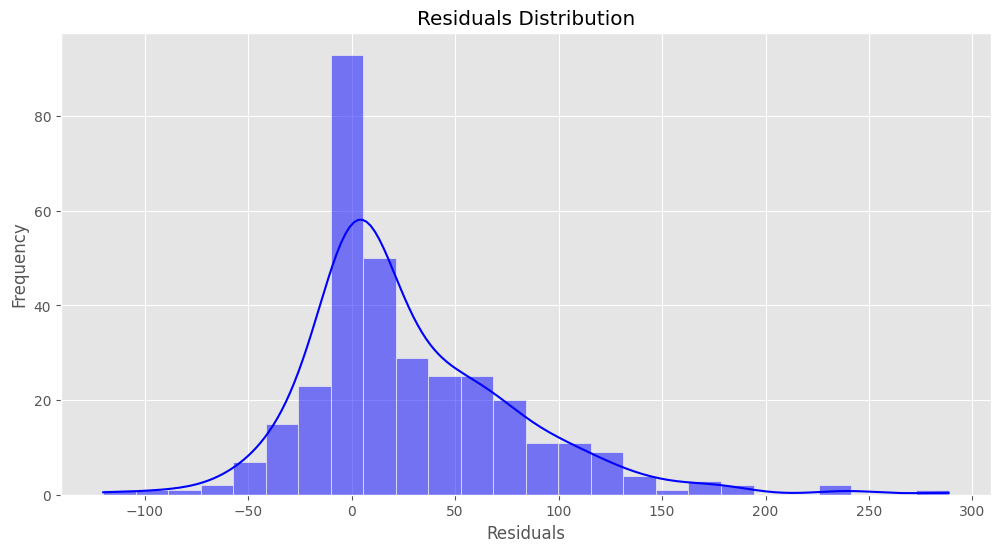

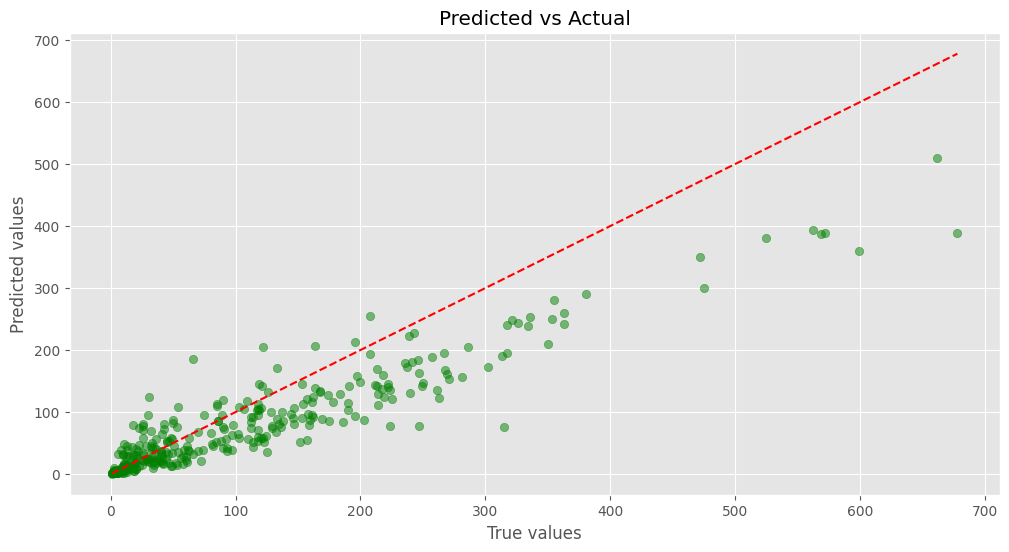

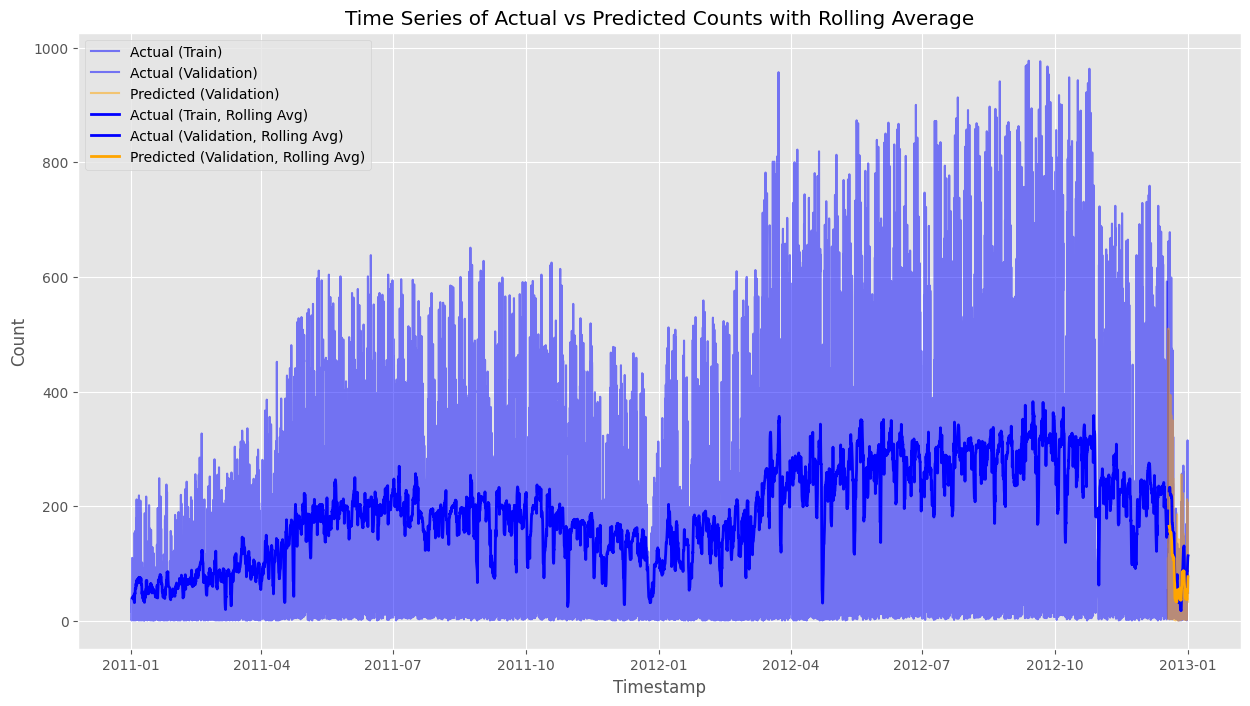

In [173]:
train_df['timestamp'] = pd.to_datetime({
	'year': train_df['year'], 
	'month': train_df['month'], 
	'day': train_df['day_of_month']
}) + pd.to_timedelta(train_df['hour'], unit='h')

val_df['timestamp'] = pd.to_datetime({
	'year': val_df['year'], 
	'month': val_df['month'], 
	'day': val_df['day_of_month']
}) + pd.to_timedelta(val_df['hour'], unit='h')

residuals = y_val - y_pred
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_pred, alpha=0.5, color='green')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predicted vs Actual')
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(train_df['timestamp'], train_df[target], label='Actual (Train)', color='blue', alpha=0.5)
plt.plot(val_df['timestamp'], y_val, label='Actual (Validation)', color='blue', alpha=0.5)
plt.plot(val_df['timestamp'], y_pred, label='Predicted (Validation)', color='orange', alpha=0.5)
plt.plot(train_df['timestamp'], train_df[target].rolling(window=24).mean(), label='Actual (Train, Rolling Avg)', color='blue', linewidth=2)
plt.plot(val_df['timestamp'], y_val.rolling(window=24).mean(), label='Actual (Validation, Rolling Avg)', color='blue', linewidth=2)
plt.plot(val_df['timestamp'], pd.Series(y_pred).rolling(window=24).mean(), label='Predicted (Validation, Rolling Avg)', color='orange', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.title('Time Series of Actual vs Predicted Counts with Rolling Average')
plt.legend()
plt.show()


In [174]:
# Log1p transformation
X_train = train_df[features]
y_train = train_df[target]

# Fit model
tuned_regressor.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['temp', 'atemp', 'hour_sin',
                                                   'hour_cos', 'week_cos',
                                                   'weather_hum',
                                                   'temp_atemp']),
                                                 ('cat_label',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_valu...
                                                   'is_night',
                                                   'rush_hour'])])),
                ('regressor',
                 TransformedTargetRegressor(func=<function func at 0x000001E9BFC4C720>,
                                            inverse_func=<function inverse_func at 0x000001E9BFC4CCC0>,
                                            regressor=LGBMRegressor(colsample_bytree=0.5,
                                                                    learning_rate=0.08,
                                                                    max_depth=10,
                                                                    min_child_samples=25,
                                                                    n_estimators=130,
                                                                    num_leaves=95,
                                                                    reg_alpha=0.07,
                                                                    reg_lambda=0.37,
                                                                    subsample=0.56,
                                                                    verbosity=-1)))])

In [175]:
X_val = val_df[features]
y_val = val_df[target]
y_pred = tuned_regressor.predict(X_val)

# Metrics
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

logging.info(f"RMSE: {rmse}")


c:\Users\Lawrence\Documents\PYTHON\bike_demand_2025\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
2025-03-10 23:28:12,100 - INFO - RMSE: 60.670273708156095


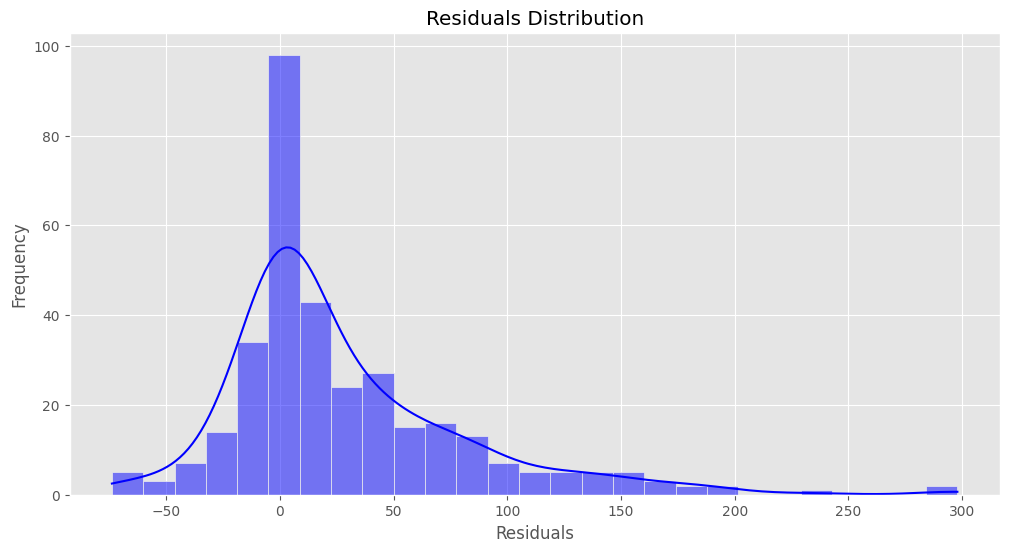

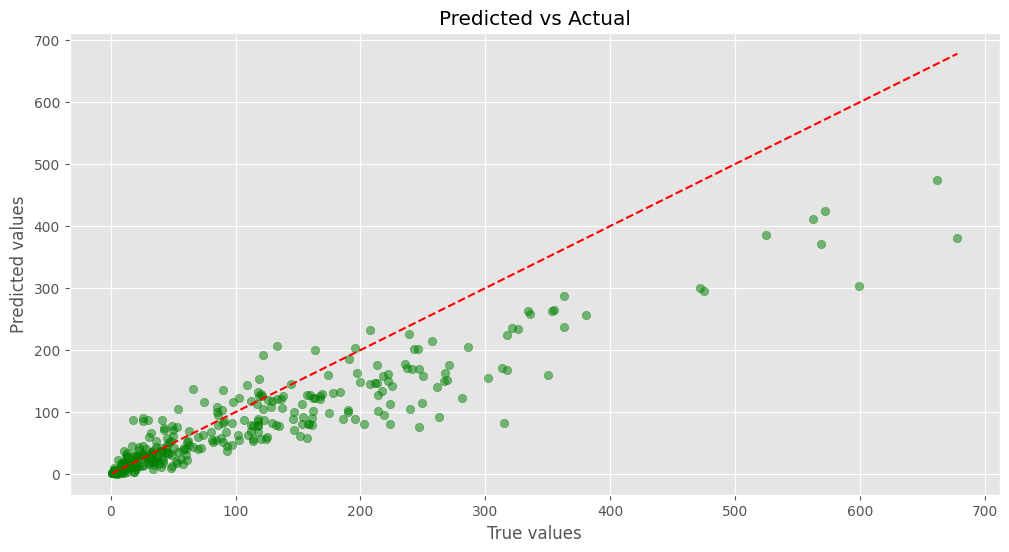

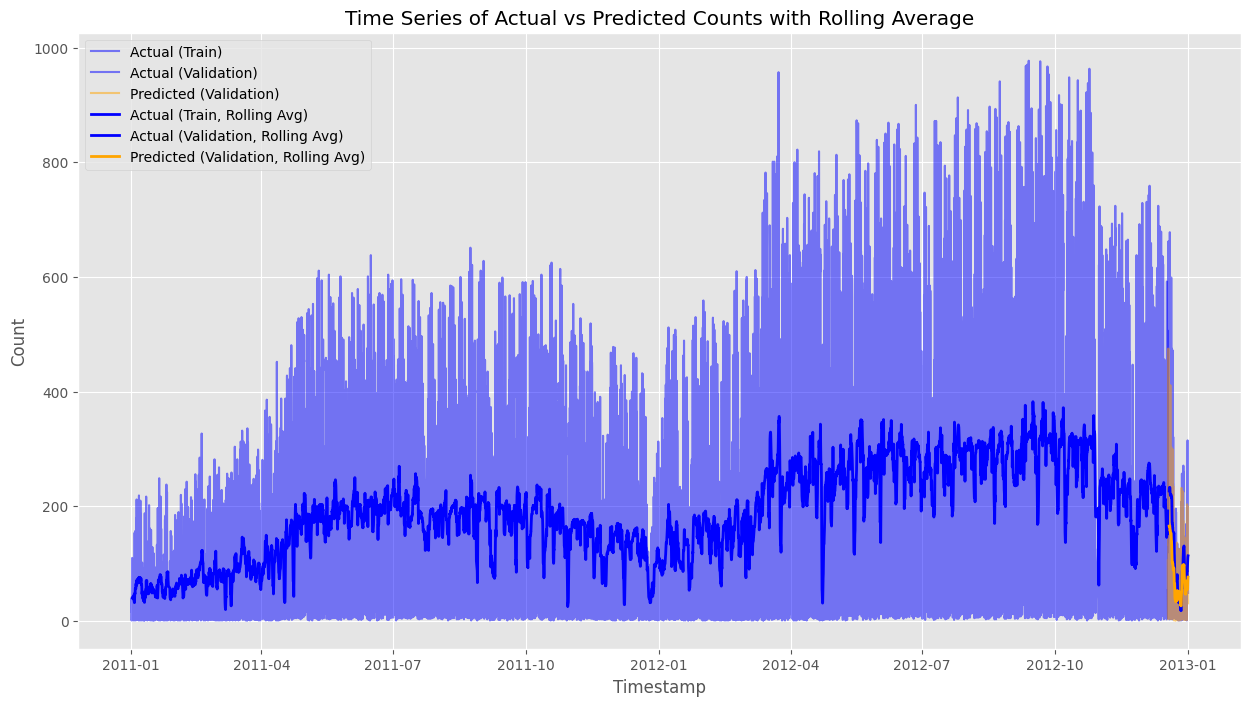

In [176]:
train_df['timestamp'] = pd.to_datetime({
	'year': train_df['year'], 
	'month': train_df['month'], 
	'day': train_df['day_of_month']
}) + pd.to_timedelta(train_df['hour'], unit='h')

val_df['timestamp'] = pd.to_datetime({
	'year': val_df['year'], 
	'month': val_df['month'], 
	'day': val_df['day_of_month']
}) + pd.to_timedelta(val_df['hour'], unit='h')

residuals = y_val - y_pred
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_pred, alpha=0.5, color='green')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predicted vs Actual')
plt.show()

plt.figure(figsize=(15, 8))
plt.plot(train_df['timestamp'], train_df[target], label='Actual (Train)', color='blue', alpha=0.5)
plt.plot(val_df['timestamp'], y_val, label='Actual (Validation)', color='blue', alpha=0.5)
plt.plot(val_df['timestamp'], y_pred, label='Predicted (Validation)', color='orange', alpha=0.5)
plt.plot(train_df['timestamp'], train_df[target].rolling(window=24).mean(), label='Actual (Train, Rolling Avg)', color='blue', linewidth=2)
plt.plot(val_df['timestamp'], y_val.rolling(window=24).mean(), label='Actual (Validation, Rolling Avg)', color='blue', linewidth=2)
plt.plot(val_df['timestamp'], pd.Series(y_pred).rolling(window=24).mean(), label='Predicted (Validation, Rolling Avg)', color='orange', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.title('Time Series of Actual vs Predicted Counts with Rolling Average')
plt.legend()
plt.show()
